In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

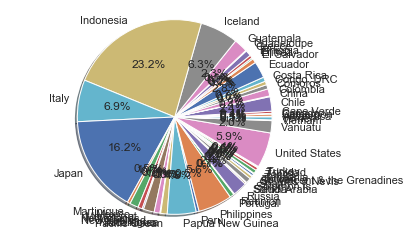

In [6]:
labels = vol['Country'].astype('category').cat.categories.tolist()
counts = vol['Country'].value_counts()
sizes = [counts[var_cat] for var_cat in labels]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True) #autopct is show the % on plot
ax1.axis('equal')
plt.show()

In [7]:
vol  = vol[['Year','Month','Day','Latitude','Longitude']]

In [8]:
vol.head()

,Year,Month,Day,Latitude,Longitude
0,-4360,NaN,NaN,-30.200,-178.470
1,-4350,NaN,NaN,30.780,130.280
2,-4050,NaN,NaN,11.984,-86.161
3,-4000,NaN,NaN,-5.580,150.520
4,-3580,NaN,NaN,14.002,120.993


In [10]:
vol  = vol.fillna(vol['Month'].value_counts().index[0])
vol  = vol.fillna(vol['Day'].value_counts().index[0])

In [11]:
vol.head()

,Year,Month,Day,Latitude,Longitude
0,-4360,8.0,8.0,-30.200,-178.470
1,-4350,8.0,8.0,30.780,130.280
2,-4050,8.0,8.0,11.984,-86.161
3,-4000,8.0,8.0,-5.580,150.520
4,-3580,8.0,8.0,14.002,120.993


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

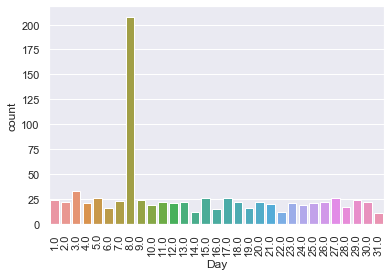

In [12]:
g = sns.countplot(vol['Day'])
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

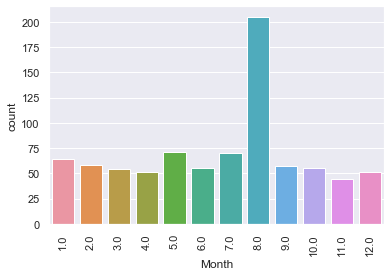

In [13]:
g =sns.countplot(vol['Month'])
plt.xticks(rotation = 90)

In [14]:
### Using the mode to replace the NaN values looks like it may affect the dataset.

In [15]:
volc = pd.read_csv('data/txt/volerup.txt',delimiter = '\t', quoting = 3, encoding='utf-8')

In [16]:
volc  = volc[['Year','Month','Day','Name','Latitude','Longitude']]

In [17]:
volc = volc.dropna()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]),
 <a list of 31 Text xticklabel objects>)

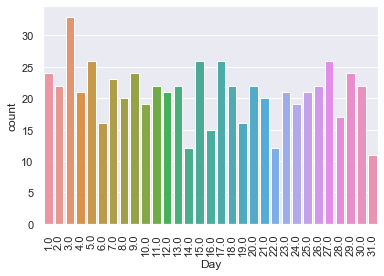

In [18]:
g = sns.countplot(volc['Day'])
plt.xticks(rotation = 90)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 <a list of 12 Text xticklabel objects>)

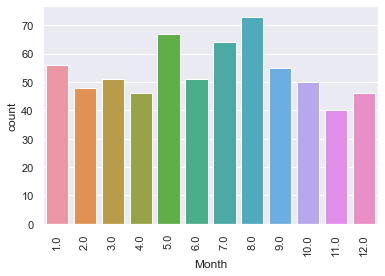

In [19]:
g = sns.countplot(volc['Month'])
plt.xticks(rotation = 90)

In [20]:
volc.head()

,Year,Month,Day,Latitude,Longitude
29,79,8.0,25.0,40.821,14.426
43,766,7.0,20.0,31.580,130.670
52,1104,10.0,15.0,63.980,-19.700
54,1158,1.0,19.0,63.980,-19.700
55,1169,2.0,4.0,37.734,15.004


In [21]:
volc.shape

(647, 5)

In [23]:
train = volc[0:600]
test = volc[600:]

In [24]:
from sklearn.preprocessing import MinMaxScaler
sc =MinMaxScaler(feature_range = (0,1))
scaled_set = sc.fit_transform(train)

In [25]:
time_steps = 30
length =  len(scaled_set)
col = volc.shape[1]

In [26]:
# creating the time steps
x_train = []
y_train = []

for i in range(time_steps, length):
    x_train.append(scaled_set[i-time_steps:i, :])  
    y_train.append(scaled_set[i,:])

In [27]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [28]:
x_train = np.reshape(x_train,(x_train.shape[0], x_train.shape[1], col))

In [29]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend
from keras.models import load_model

Using TensorFlow backend.


In [30]:
# f beta metric, incase of imbalanced dataset ...... 
def f_beta(y_true, y_pred, beta =2):
    # clip prediction
    y_pred = backend.clip(y_pred, 0, 1)
    
    # calculate elements
    tp = backend.sum(backend.round(backend.clip(y_true * y_pred, 0,1)), axis = 1)
    fp = backend.sum(backend.round(backend.clip(y_pred - y_true, 0,1)), axis = 1)
    fn = backend.sum(backend.round(backend.clip(y_true - y_pred, 0,1)), axis = 1)
    
    #  precision
    p = tp / (tp + fp + backend.epsilon())
    
    #  recall
    r = tp / (tp +fn + backend.epsilon())
    
    # calculate fbeta
    
    bb = beta ** 2
    fbeta_score = backend.mean((1 + bb) * (p * r) / (bb * p + r + backend.epsilon()))
    return fbeta_score
    

In [31]:
# 6 layer LSTM 0f 35 neurons each.
detector = Sequential()
detector.add(LSTM(units = 60, return_sequences = True, input_shape = (x_train.shape[1], col)))
detector.add(Dropout(0.3))
detector.add(LSTM(units = 60, return_sequences =True))
detector.add(Dropout(0.3))
detector.add(LSTM(units = 60, return_sequences =True))
detector.add(Dropout(0.3))
detector.add(LSTM(units = 60, return_sequences =True))
detector.add(Dropout(0.3))
detector.add(LSTM(units = 60, return_sequences =True))
detector.add(Dropout(0.3))
detector.add(LSTM(units = 60))
detector.add(Dropout(0.3))
detector.add(Dense(units=col))
detector.compile(optimizer = 'RMSprop', loss = 'mean_squared_error', metrics = [f_beta])

In [33]:
detector.fit(x_train, y_train, epochs = 6, batch_size = 30)

Epoch 1/6
570/570 [==============================] - 4s 8ms/step - loss: 0.0786 - f_beta: 0.9046
Epoch 2/6
570/570 [==============================] - 2s 4ms/step - loss: 0.0756 - f_beta: 0.9169
Epoch 3/6
570/570 [==============================] - 2s 4ms/step - loss: 0.0755 - f_beta: 0.9205
Epoch 4/6
570/570 [==============================] - 2s 4ms/step - loss: 0.0729 - f_beta: 0.9235
Epoch 5/6
570/570 [==============================] - 2s 4ms/step - loss: 0.0737 - f_beta: 0.9268
Epoch 6/6
570/570 [==============================] - 2s 4ms/step - loss: 0.0725 - f_beta: 0.9200


### Test dataset

In [34]:
test.head()

,Year,Month,Day,Latitude,Longitude
787,2014,2.0,1.0,3.170,98.392
788,2014,2.0,13.0,-7.930,112.308
789,2014,9.0,27.0,35.900,137.480
790,2014,11.0,10.0,19.425,-155.292
791,2014,11.0,23.0,14.950,-24.350


In [36]:
length = len(test)

In [37]:
total_data = pd.concat((train, test), axis = 0)

In [38]:
inputs = total_data[len(train) - len(test) - time_steps :].values
inputs = inputs.reshape(-1,col)

In [39]:
inputs = sc.transform(inputs)

In [41]:
value = time_steps + length

In [42]:
x_test = []
for i in range(time_steps, value):                
    x_test.append(inputs[i - time_steps: i, : ])   

In [43]:
x_test= np.array(x_test)
x_test.shape

(47, 30, 5)

In [44]:
x_test = np.reshape(x_test,(x_test.shape[0], x_test.shape[1], col))

In [45]:
predicted_values = detector.predict(x_test)
predicted_values = sc.inverse_transform(predicted_values)

In [47]:
pred_df = pd.DataFrame(predicted_values, columns= test.columns)

In [49]:
pred_df = pred_df.round()
pred_df.head()

,Year,Month,Day,Latitude,Longitude
0,2028.0,6.0,18.0,23.0,62.0
1,2028.0,6.0,18.0,23.0,62.0
2,2028.0,6.0,18.0,23.0,62.0
3,2028.0,6.0,18.0,23.0,62.0
4,2029.0,6.0,18.0,23.0,62.0


In [50]:
test.head()

,Year,Month,Day,Latitude,Longitude
787,2014,2.0,1.0,3.170,98.392
788,2014,2.0,13.0,-7.930,112.308
789,2014,9.0,27.0,35.900,137.480
790,2014,11.0,10.0,19.425,-155.292
791,2014,11.0,23.0,14.950,-24.350


In [ ]:
# Due to the long and lat coordinates it gave i would not be be going on with this process...